In [80]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
pd.options.mode.chained_assignment = None

In [81]:
DATA = []
BUCKETS = [0, 0.05, 0.1, 0.25, 0.5, np.Inf]

In [82]:
import json

def get_data_from_file(filename: str):
    f = open(filename, "r")
    data = []
    while True:
        line = f.readline()
        if not line:
            break
        # Standardlize json to dict
        row = json.loads(line)
        # Append to Array
        data.append(row)
    return data

In [83]:
data = get_data_from_file("../statics/requests.json")
raw_df = pd.DataFrame(columns=['timestamp', "request_id", 'duration_time'], data=data)
raw_df

,timestamp,request_id,duration_time
0,"22/02/2024, 00:00:00",4141b661-8ee5-4bea-81ec-d423210a133c,0.427
1,"22/02/2024, 00:05:00",78102b3e-5079-4ae9-b17b-5574688515d4,0.275
2,"22/02/2024, 00:10:00",5ec937ae-8273-4f00-b616-972fbfc9f1b2,0.400
3,"22/02/2024, 00:15:00",9d0343bd-e6ea-4dcb-9593-0d7e6b8fde70,1.422
4,"22/02/2024, 00:20:00",b4cf69cf-00a3-41bd-917f-0282eb56768e,0.759
5,"22/02/2024, 00:25:00",86ea4965-382a-486d-8a8c-e4ef9d2f9cd1,0.689
6,"22/02/2024, 00:30:00",9a562470-f811-4492-a34a-fb0acc60e358,1.618
7,"22/02/2024, 00:35:00",20c2a16a-fec9-4a4f-ab98-5dd281f8ab2e,0.124
8,"22/02/2024, 00:40:00",cc4cf444-782f-4904-a36e-0a14d5c6bf9d,0.055
9,"22/02/2024, 00:45:00",65201479-41af-4338-bc1a-e74b7ec37b20,1.327


In [84]:
data = [
    [5, 0, 0],
    [5, 0.025, 2],
    [5, 0.050, 3],
    [5, 0.1, 3],
    [5, "+inf", 3],
    
    [10, 0, 1],
    [10, 0.025, 5],
    [10, 0.050, 6],
    [10, 0.1, 6],
    [10, "+inf", 8],
    
    [15, 0, 9],
    [15, 0.025, 10],
    [15, 0.050, 12],
    [15, 0.1, 17],
    [15, "+inf", 17]

]
df = pd.DataFrame(columns=['minutes', 'buckets', 'count'], data=data)
df = df.pivot(index="minutes", columns="buckets", values="count")
df

buckets,0,0.025,0.05,0.1,+inf
minutes,,,,,
5,0,2,3,3,3
10,1,5,6,6,8
15,9,10,12,17,17


Thực hiện biểu diễn những giá trị lên biểu đồ:

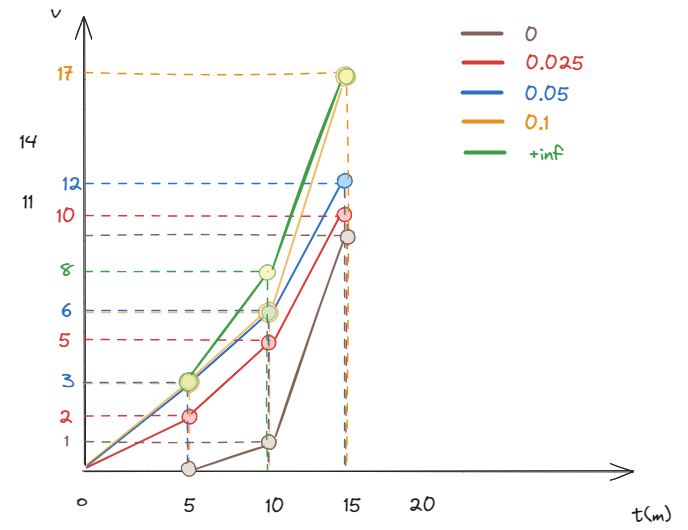

Các giá trị về số lượng phần tử được fill vào các buckets được biểu diễn theo trục Oy và sẽ tăng trưởng theo thời gian t (trục Ox)

### Phân tích biểu đồ

Xét tại 1 thời điểm t = 5 (minutes):

    - Bucket le=0 bao gồm 0 request đã được fill vào
    - Bucket le=0.025 bao gồm 2 requests đã được fill vào
    - Bucket le=0.05 có 3 requests đã được fill vào
    - Bucket le=0.1 có 3 requests đã được fill vào
    - Bucket le=+inf có 3 requests đã được fill vào
    
Vì vậy, Trong khoảng thời gian t = 5 số request tăng trưởng theo mỗi bucket được tăng như sau:

- Bucket range [0 -> 0.025] tăng: 
$\Delta$ v = 2 - 0 = 2 (có 2 request nằm trong khoảng này)
- Bucket range [0.025 -> 0.05] tăng: 
$\Delta$ v = 3 - 2 = 1 (có 1 request nằm trong khoảng này)
- Bucket range [0.05 -> 0.1] tăng: 
$\Delta$ v = 3 - 3 = 0 => Từ bucket 0.05 -> 0.1 không có sự tăng trưởng, vì vậy không có requests nào rơi vào khoảng này
- Bucket range [0.1 -> +inf] tăng: 
$\Delta$ v = 3 - 3 = 0 => Từ bucket 0.1 -> +inf không có sự tăng trưởng, vì vậy không có requests nào rơi vào khoảng này

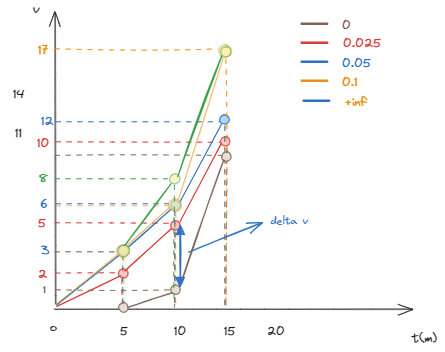
    
Các thời điểm khác phân tích tương tự

### Xác định tăng trưởng buckets theo dòng thời gian để tính toán percentile latency

Để xét tăng trưởng của bucket theo dòng thời gian, dựa vào biểu đồ trên thì thực hiện xét điểm dữ liệu hiện tại so với điểm dữ liệu trước đó, bucket nào có độ dốc nhiều hơn thì dữ liệu sẽ biến động nhiều hơn ở bucket đó.

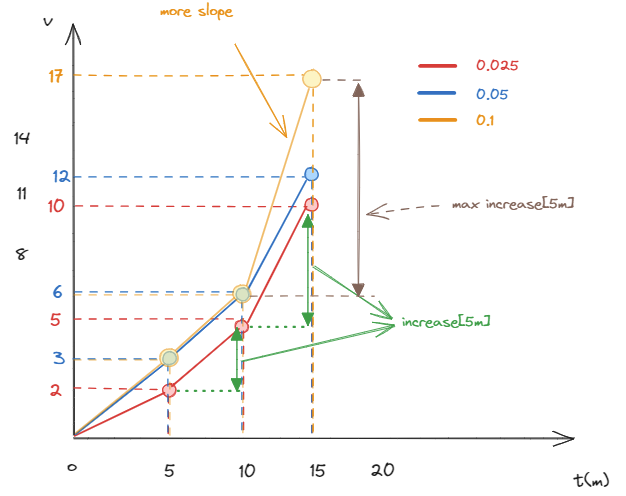

Từ biểu đồ trên có thể suy ra công thức tính tăng trưởng dữ liệu tại thời điểm  **t** sau mỗi khoảng $\Delta$ t:


**increase[t] = v[t] - v[t - $\Delta$ t]**

Đây là công thức được Prometheus sử dụng để tính giá trị tăng trưởng giữa các khoảng thời gian. Chi tiết xem tại: https://prometheus.io/docs/prometheus/latest/querying/functions/#increase




In [85]:
df

buckets,0,0.025,0.05,0.1,+inf
minutes,,,,,
5,0,2,3,3,3
10,1,5,6,6,8
15,9,10,12,17,17


In [86]:
buckets = [0, 0.025, 0.05, 0.1, "+inf"]
# Calculate increase()
first_row = df.iloc[0].to_dict()
df[buckets].diff().fillna(first_row)

buckets,0,0.025,0.05,0.1,+inf
minutes,,,,,
5,0.0,2.0,3.0,3.0,3.0
10,1.0,3.0,3.0,3.0,5.0
15,8.0,5.0,6.0,11.0,9.0


Từ đó suy ra được công thức tính tỉ lệ tăng trưởng trung bình:

_Vì các time interval input là đa dạng (m,s,h,d) nên Prometheus lấy đơn vị thời gian nhỏ nhất là second để tính giá trị trung bình_

**_Công thức tính tỉ lệ tăng trưởng trung bình tại thời điểm **t** sau mỗi khoảng $\Delta$ t:_**

**rate[t] = (v[t] - v[t - $\Delta$ t]) / t**

<u>Ví dụ: rate[5m] = (v[t] - v[t - 5m]) / (5 * 60)</u>

In [87]:
# Calculate rate(5m)
first_row = df.iloc[0].to_dict()
df[buckets].diff().fillna(first_row) / (5 * 60)

buckets,0,0.025,0.05,0.1,+inf
minutes,,,,,
5,0.000000,0.006667,0.01,0.010000,0.010000
10,0.003333,0.010000,0.01,0.010000,0.016667
15,0.026667,0.016667,0.02,0.036667,0.030000


_Khi đã xác định được mức độ tăng trưởng của buckets tại một thời điểm, lúc này sẽ có thể xác định được giá trị latency percentile dựa vào giá trị tăng trưởng trung bình (rate). Ví dụ, khi muốn tính toán 95th latency percentile nghĩa là sẽ tìm ra bucket range có 95% requests rơi vào._

----

#### Calculate latency percentile

Vì histogram buckets của Prometheus có điểm start range bucket luôn luôn là 0 nên giá trị của bucket lớn nhất cũng sẽ bao gồm những giá trị của bucket nhỏ hơn. Lúc này, giá trị tăng trưởng trung bình của bucket lớn nhất tại 1 thời điểm (trong trưởng hợp này là +Inf) sẽ là giá trị **n**

_Ví dụ: Tính 95th percentile latency tại thời điểm t=15m_


In [88]:
first_row = df.iloc[0].to_dict()
# Calculate rate[5m]
df_rate = df[[0.025, 0.050, 0.100]].diff().fillna(first_row) / (5 * 60)
df_rate

buckets,0.025,0.05,0.1
minutes,,,
5,0.006667,0.01,0.010000
10,0.010000,0.01,0.010000
15,0.016667,0.02,0.036667


#### Phân tích tỉ lệ tăng trưởng buckets tại một thời điểm bất kì

Đây là thuật toán mà Prometheus sử dụng để tính toán tỉ lệ tăng trưởng tại các buckets theo dòng thời gian. Vì histogram được sử dụng trong Prometheus phân chia bucket range start từ 0 nên counter của các bucket lớn hơn sẽ bao gồm cả counter của bucket nhỏ hơn. (Buckets: 0->0.025, 0->0.05, -> 0->0.1)

_Ví dụ: Bucket **le=+Inf** sẽ bao gồm phần tử của **le=0.5 và le=0.25** hoặc bucket **le=0.5** bao gồm các phần tử của bucket **le=0.25**_

**Vậy nên, khi biểu diễn các buckets trên biểu đồ thì các giá trị của bucket nhỏ hơn sẽ không bao giờ vượt quá ngưỡng giá trị của các bucket lớn hơn tại một thời điểm**

Tham khảo thêm: https://prometheus.io/docs/tutorials/understanding_metric_types/#histogram

----

Để xét tăng trưởng của bucket theo dòng thời gian, dựa vào biểu đồ trên thì thực hiện xét điểm dữ liệu hiện tại so với điểm dữ liệu trước đó, bucket nào có độ dốc nhiều hơn thì dữ liệu biến động nhiều hơn ở bucket đó.